In [238]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [239]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [240]:
len(words)

32033

In [241]:
# build vocab of char and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [242]:
# build ds

block_size = 3 # context length
X, Y = [], []
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch] 
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [243]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [244]:
# build ds new

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print w
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] 
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [245]:
C = torch.randn((27, 2))

In [246]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [247]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [248]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [249]:
a.shape

torch.Size([18])

In [250]:
a.view(3,6)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])

In [251]:
emb.view(32,6)

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [ ]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [ ]:
h

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logs = h @ W2 + b2

In [ ]:
logs.shape

In [ ]:
logs

In [ ]:
counts = logs.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

In [ ]:
prob[0].sum()

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [ ]:
# ------------more respectable ----------

In [287]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [288]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [289]:
sum(p.nelement() for p in parameters)

11897

In [290]:
for p in parameters:
    p.requires_grad = True

In [291]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [292]:
# lri = []
lossi = []
stepi = []

In [293]:
for i in range(200000):

    #choose minibatch
    ix = torch.randint(0,Xtr.shape[0],(32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    

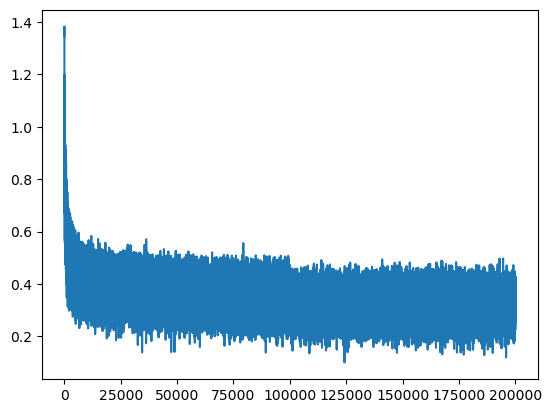

In [294]:
plt.plot(stepi,lossi)

In [295]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1186, grad_fn=<NllLossBackward0>)

In [296]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1659, grad_fn=<NllLossBackward0>)

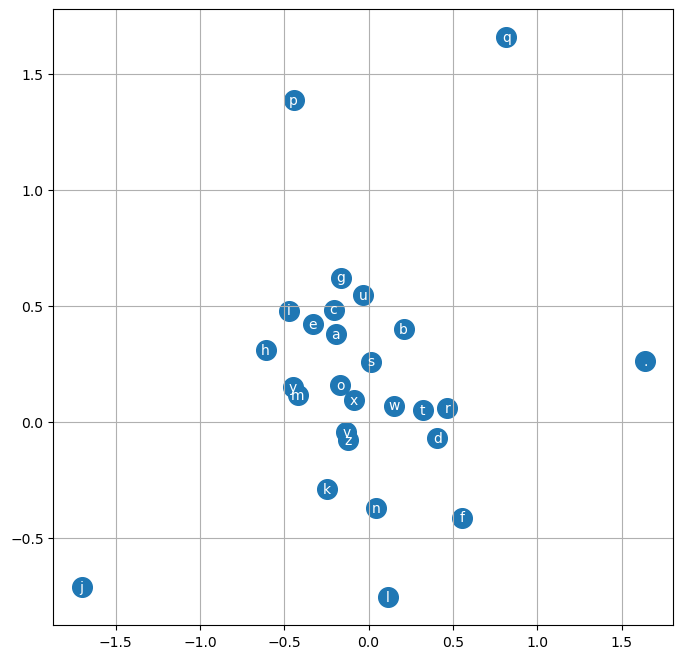

In [297]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [300]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []

    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] 
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
milia.
atyannah.
sae.
rahnen.
delyah.
parqui.
nellara.
chaiir.
kaleigh.
ham.
pois.
quinn.
shon.
emi.
adbi.
waythogiearynix.
kaeilinsley.
